In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importing all the libraries
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%time

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 14197, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 14197 (delta 84), reused 99 (delta 64), pack-reused 14060
Receiving objects: 100% (14197/14197), 13.55 MiB | 25.56 MiB/s, done.
Resolving deltas: 100% (9747/9747), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 5.3 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
     |████████████████████████████████| 1.6 MB 42.0 MB/s 
CPU times: user 149 ms, sys: 62 ms, total: 211 ms
Wall time: 12 s


In [5]:
image_h, image_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/drive/MyDrive/archive/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/image_w
df['w'] = df['w']/image_w
df['y_center'] = df['y_center']/image_h
df['h'] = df['h']/image_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [6]:
index = list(set(df.image_id))
img = random.choice(index)
print("Image ID: %s"%(img))
image = cv2.imread(f'/content/drive/MyDrive/archive/data/training_images/{img}.jpg')
image.shape

Image ID: vid_4_29940


(380, 676, 3)

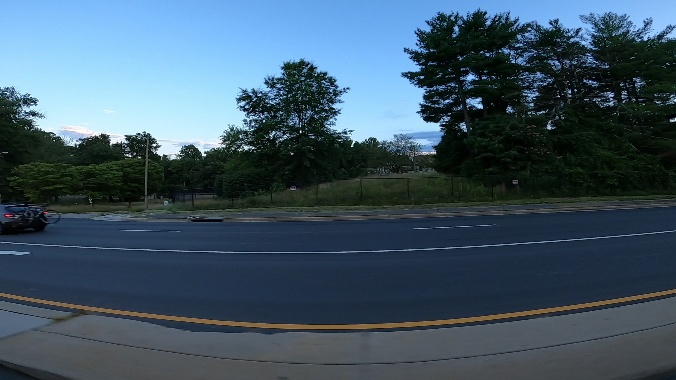

In [7]:
img = random.choice(index)
Image(filename=f'/content/drive/MyDrive/archive/data/training_images/{img}.jpg',width=400)

In [8]:
src = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/drive/MyDrive/archive/data/{}/{}.jpg".format(src,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [10]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/drive/MyDrive/archive/data/training_images/ 

detect: weights=['yolov5/yolov5s.pt'], source=/content/drive/MyDrive/archive/data/training_images/, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-10-g10c025d Python-3.7.15 torch-1.12.1+cu113 CPU

100% 14.1M/14.1M [00:00<00:00, 45.6MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/1001 /content/drive/MyDrive/archive/data/training_images/vid_4_1000.jpg: 416x704 1 car, 378.3ms
image 2/1001 /content/drive/MyDrive/archive/data/training_images/vid_4_10000.jpg: 416x704 1 car, 327.7ms
image 3

In [27]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)

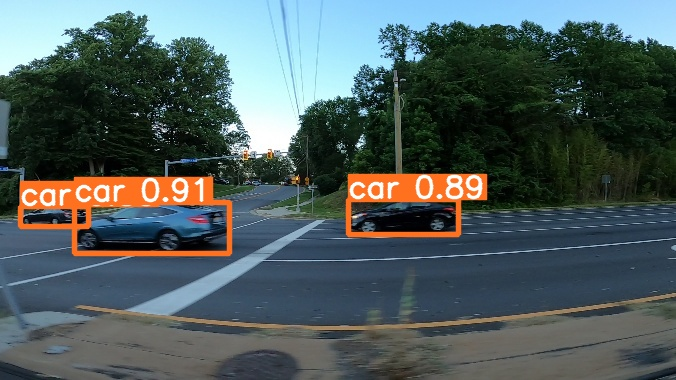

In [28]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

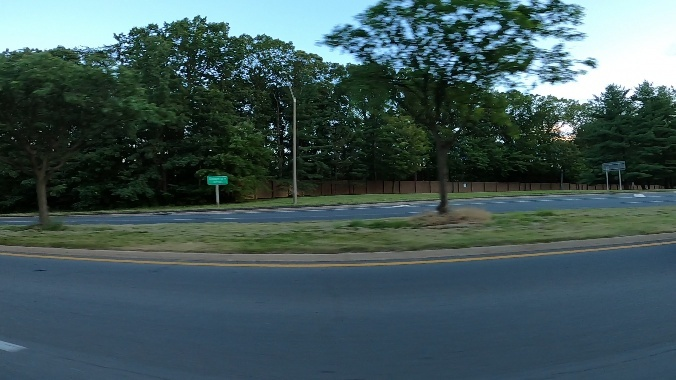

In [29]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

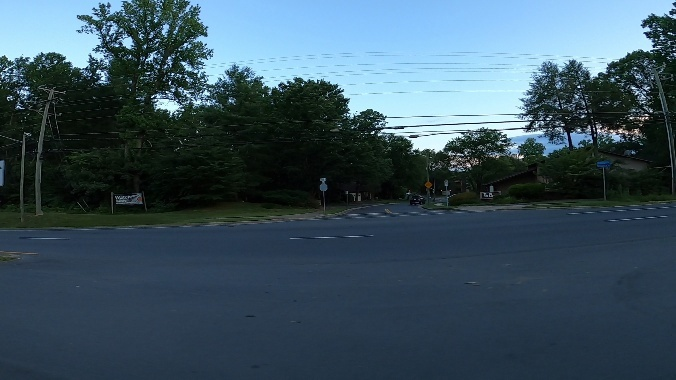

In [30]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

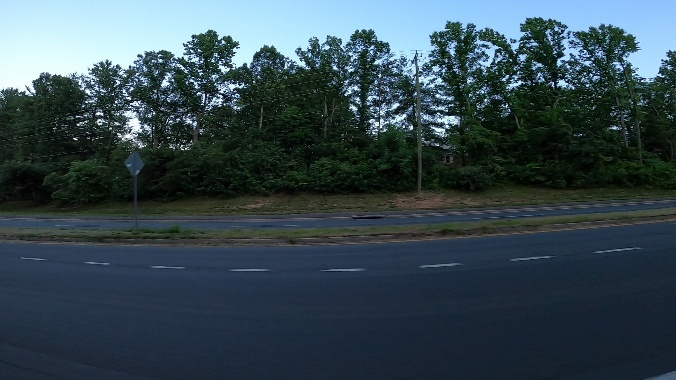

In [31]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

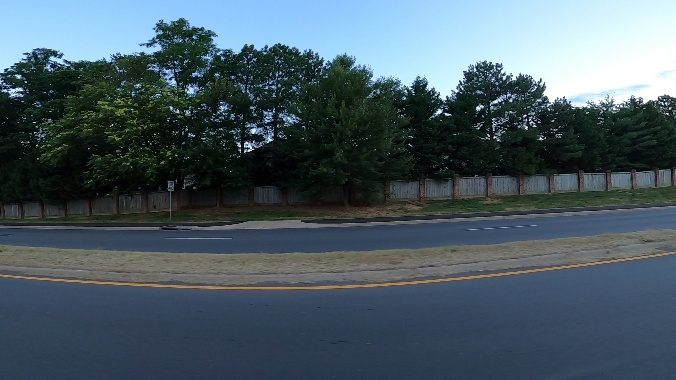

In [32]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

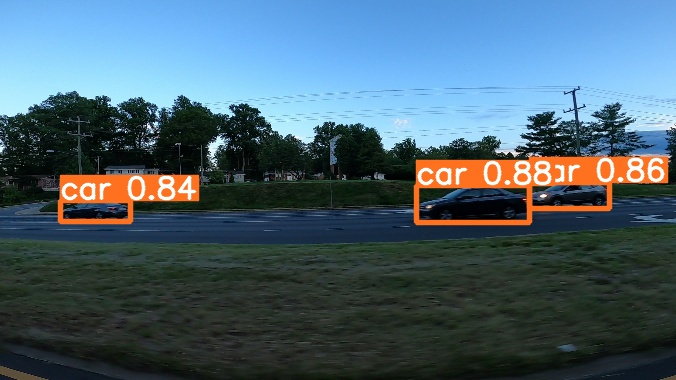

In [33]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

In [ ]:
!rm -rf runs yolov5